In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
import shap
from dotenv import load_dotenv
from pathlib import Path
import os
load_dotenv()  
import warnings
warnings.filterwarnings("ignore")

data_dir = Path(os.getenv("DATA_DIR"))

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (7, 4)

In [29]:

trx = pd.read_csv(data_dir / "transactions_csv.txt", parse_dates=["date"])
users = pd.read_csv(data_dir / "users_csv.txt")
tax = pd.read_csv(data_dir / "tax_filings_csv.txt")

In [53]:
def quality_report(df: pd.DataFrame, name: str) -> None:
    """Print missing‑value counts and duplicate rows per DataFrame."""
    print("Missing values (count):")
    print(df.isna().sum())
    print(f"Duplicate rows: {df.duplicated().sum()}")


def flag_outliers(df: pd.DataFrame, name: str, z_thresh: float = 3.0) -> None:
    """
    Flag rows with any numeric column exceeding |z| > z_thresh.
    Prints how many potential outliers were found.
    """
    num = df.select_dtypes("number")
    if num.empty:
        print(f"{name}: no numeric columns to scan for outliers.")
        return
    z = (num - num.mean()) / num.std(ddof=0)
    outlier_mask = (np.abs(z) > z_thresh).any(axis=1)
    print(f"{name}: {outlier_mask.sum()} potential outliers (|z| > {z_thresh}).")

In [54]:
if not pd.api.types.is_datetime64_any_dtype(trx["date"]):
    trx["date"] = pd.to_datetime(trx["date"], errors="coerce")

trx["amount"] = pd.to_numeric(trx["amount"], errors="coerce")
tax["total_income"] = pd.to_numeric(tax["total_income"], errors="coerce")
tax["total_deductions"] = pd.to_numeric(tax["total_deductions"], errors="coerce")
tax["refund_amount"] = pd.to_numeric(tax["refund_amount"], errors="coerce")

trx.dropna(subset=["amount", "date"], inplace=True)
tax.dropna(subset=["total_income", "total_deductions", "refund_amount"], inplace=True)

quality_report(trx, "transactions")
quality_report(users, "users")
quality_report(tax, "tax_filings")
flag_outliers(trx, "transactions")
flag_outliers(tax, "tax_filings")

Missing values (count):
transaction_id    0
user_id           0
date              0
amount            0
category          0
subcategory       0
description       0
vendor            1
year              0
dtype: int64
Duplicate rows: 0
Missing values (count):
user_id                0
occupation_category    0
age_range              0
family_status          0
region                 0
dtype: int64
Duplicate rows: 0
Missing values (count):
filing_id           0
user_id             0
year                0
filing_date         0
total_income        0
total_deductions    0
refund_amount       0
dtype: int64
Duplicate rows: 0
transactions: 15 potential outliers (|z| > 3.0).
tax_filings: 0 potential outliers (|z| > 3.0).


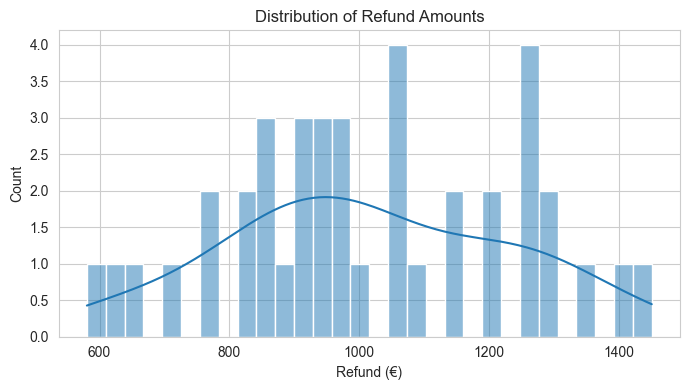

In [32]:
plt.figure()
sns.histplot(tax["refund_amount"], bins=30, kde=True)
plt.title("Distribution of Refund Amounts")
plt.xlabel("Refund (€)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

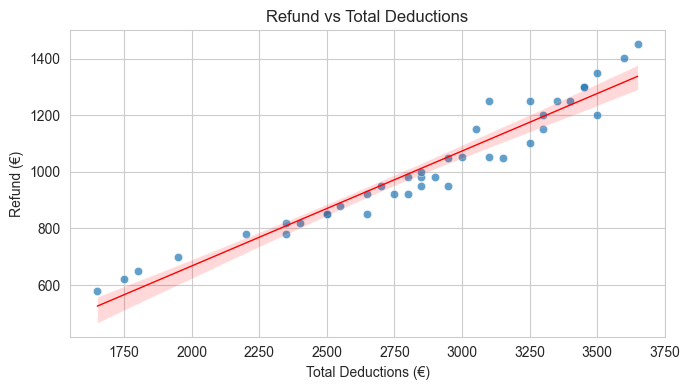

In [33]:
plt.figure()
sns.scatterplot(x=tax["total_deductions"], y=tax["refund_amount"], alpha=0.7)
sns.regplot(
    x=tax["total_deductions"],
    y=tax["refund_amount"],
    scatter=False,
    color="red",
    line_kws={"lw": 1},
)
plt.title("Refund vs Total Deductions")
plt.xlabel("Total Deductions (€)")
plt.ylabel("Refund (€)")
plt.tight_layout()
plt.show()

In [42]:
# ============================================================
# 2. Build a user × year analysis table
# ============================================================
trx["year"] = trx["date"].dt.year

# ── per-user, per-year transaction aggregates (robust pivot)
# 1. Basic totals
basic_totals = (
    trx.groupby(["user_id", "year"])
    .agg(total_spend=("amount", "sum"), num_transactions=("transaction_id", "count"))
    .reset_index()
)

# 2. Per‑category spend via pivot table (avoids lambda error)
pivot_spend = (
    trx.pivot_table(
        index=["user_id", "year"],
        columns="category",
        values="amount",
        aggfunc="sum",
        fill_value=0,
    )
    .add_prefix("spend_")
    .reset_index()
)

# 3. Merge the two parts
agg_txn = basic_totals.merge(pivot_spend, on=["user_id", "year"], how="left")

spend_cols = [c for c in agg_txn.columns if c.startswith("spend_")]

# ── per-user, per-year category-share (% of spend)
agg_txn[[f"{c}_share" for c in spend_cols]] = (
    agg_txn[spend_cols].div(agg_txn["total_spend"], axis=0).fillna(0)
)

# ── merge with filings and demographics
tax = tax.rename(columns={"tax_year": "year"})
df = (
    agg_txn.merge(tax, on=["user_id", "year"], how="left")
    .merge(users, on="user_id", how="left")
    .dropna(subset=["refund_amount"])  # keep complete rows
)

# helper numeric/cat lists
num_cols = df.select_dtypes("number").columns.tolist()
cat_cols = ["occupation_category", "region", "age_range"]

### Correlation heat-map (numeric drivers of refund €)

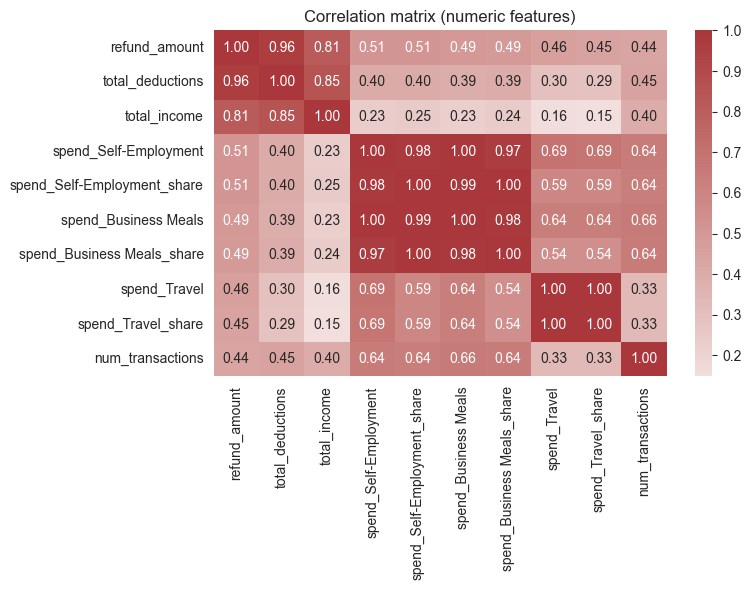

In [43]:
corr = df[num_cols].corr()["refund_amount"].sort_values(ascending=False)

num_cols_plot = [c for c in num_cols if df[c].nunique() > 1]

# 10 most correlated features with refund
top_feats = corr.index[:10].tolist()

plt.show()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    df[top_feats].corr(),
    cmap="vlag",
    center=0,
    annot=True,
    fmt=".2f",
    ax=ax
)
ax.set_title("Correlation matrix (numeric features)")
fig.tight_layout()
plt.show()

### Category 'impact' analysis (does having spend in a specific bucket help?)

                          avg_refund_with  avg_refund_without   delta
category                                                             
Travel                            1350.75              959.14  391.61
Business Meals                    1184.00              937.38  246.62
Self-Employment                   1184.00              937.38  246.62
Insurance                         1115.38              974.83  140.54
Home Office                       1006.00              974.86   31.14
Property Expenses                 1000.75              982.48   18.27
Rental                            1000.75              982.48   18.27
Charitable Donations               988.25              977.66   10.59
Child Care                         979.75              986.62   -6.88
Work Equipment                     969.65              992.00  -22.35
Medical                            959.99             1035.60  -75.61
Professional Development           923.44             1083.92 -160.48
Transportation      

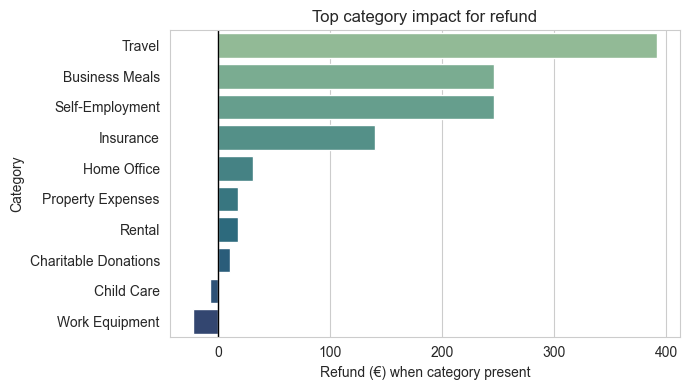

In [44]:
def category_lift(df, cat_name, spend_prefix="spend_"):
    """Return avg refund where category spend >0 vs ==0."""
    flag = df[f"{spend_prefix}{cat_name}"] > 0
    avg_with = df.loc[flag, "refund_amount"].mean()
    avg_without = df.loc[~flag, "refund_amount"].mean()
    return pd.Series(
        {
            "avg_refund_with": round(avg_with, 2),
            "avg_refund_without": round(avg_without, 2),
            "delta": round(avg_with - avg_without, 2),
        }
    )

lift_rows = []
for col in spend_cols:
    cat = col.replace("spend_", "")
    row = category_lift(df, cat)
    row["category"] = cat
    lift_rows.append(row)

lift_tbl = (
    pd.DataFrame(lift_rows).set_index("category").sort_values("delta", ascending=False)
)

print(lift_tbl)

# Bar plot for top‑10 positive deltas
top10 = lift_tbl.head(10)
plt.figure()
sns.barplot(y=top10.index, x=top10["delta"], palette="crest")
plt.axvline(0, color="k", lw=1)
plt.xlabel("Refund (€) when category present")
plt.ylabel("Category")
plt.title("Top category impact for refund")
plt.tight_layout()
plt.show()


### Does refund vary by demographic?

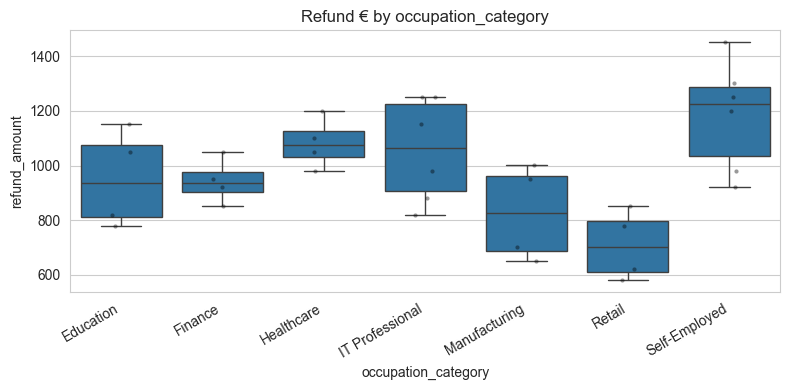

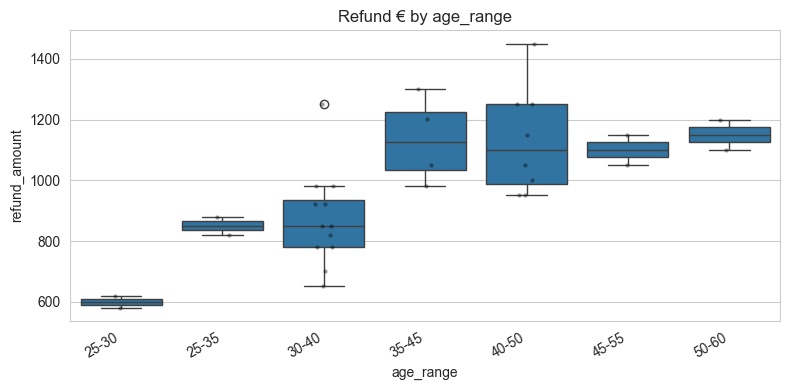

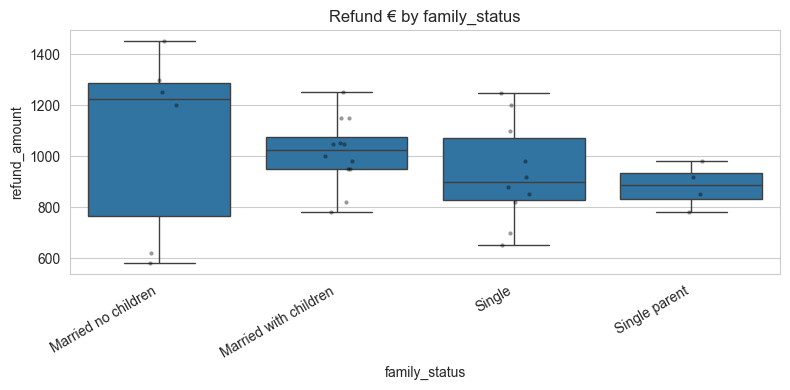

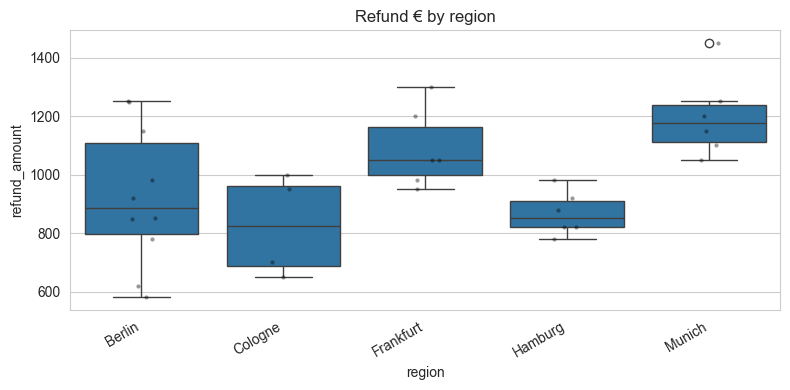

In [41]:

demo_cols = ["occupation_category", "age_range", "family_status", "region"]

for col in demo_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(
        x=col, y="refund_amount", data=df, order=sorted(df[col].dropna().unique())
    )
    sns.stripplot(x=col, y="refund_amount", data=df, color="black", size=3, alpha=0.4)
    plt.xticks(rotation=30, ha="right")
    plt.title(f"Refund € by {col}")
    plt.tight_layout()
    plt.show()

### Feature Importance XGBoost + SHAP

Model R² on all data: 1.000


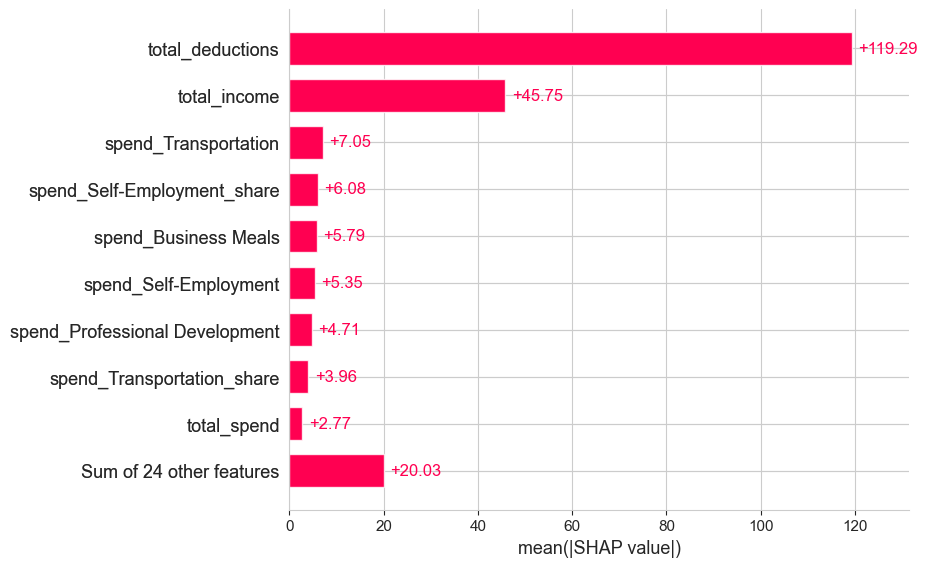

In [52]:
df_ml = df.copy()
df_ml = pd.get_dummies(df_ml, columns=cat_cols, drop_first=True)

X = df_ml.select_dtypes("number").drop(columns=["refund_amount"], errors="ignore")
y = df_ml["refund_amount"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

model = GradientBoostingRegressor(random_state=42)
model.fit(X_scaled_df, y)
print(f"Model R² on all data: {r2_score(y, model.predict(X_scaled_df)):.3f}")

explainer = shap.Explainer(model)
sh_values = explainer(X_scaled_df)

shap.plots.bar(sh_values, max_display=10, show=True)

### Random‑Forest feature importance

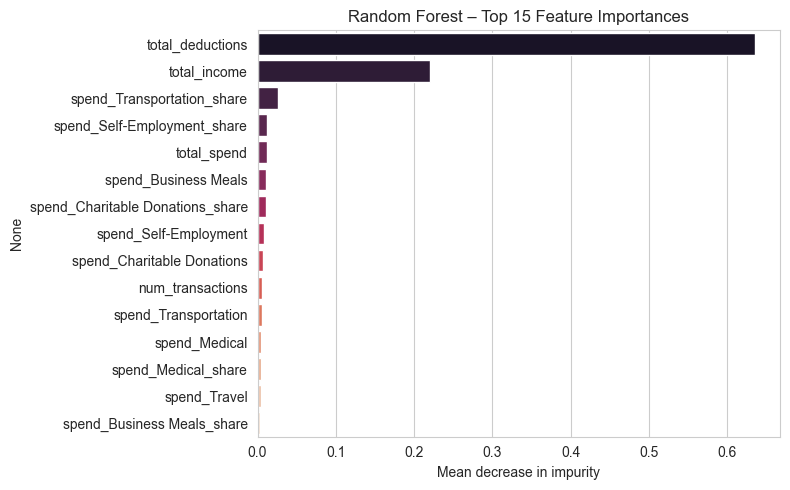

In [49]:
rf = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1)
rf.fit(X, y)

rf_importances = pd.Series(rf.feature_importances_, index=X.columns)
top_rf = rf_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 5))
sns.barplot(y=top_rf.index, x=top_rf.values, palette="rocket")
plt.xlabel("Mean decrease in impurity")
plt.title("Random Forest – Top 15 Feature Importances")
plt.tight_layout()
plt.show()